In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('yahoo_stock.csv', parse_dates=['Date'])
df = df.set_index('Date').sort_index()
freq = pd.infer_freq(df.index)
if freq is not None:
    df.index.freq = freq

df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [3]:
columns = ['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close']

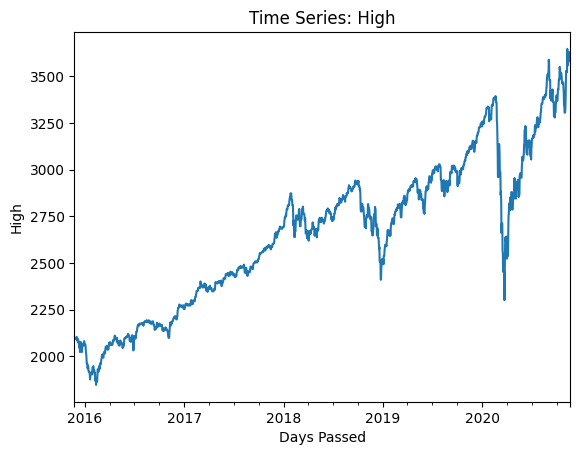

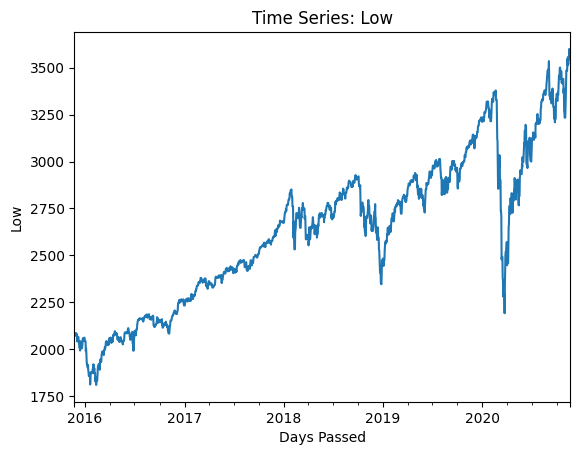

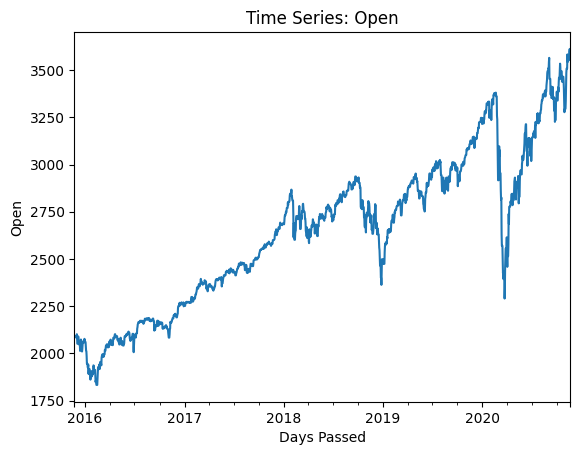

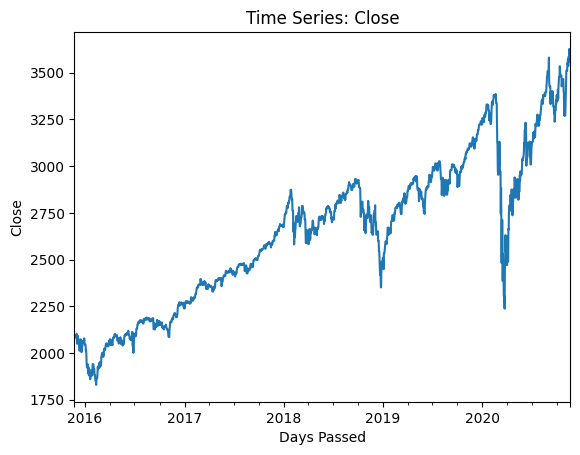

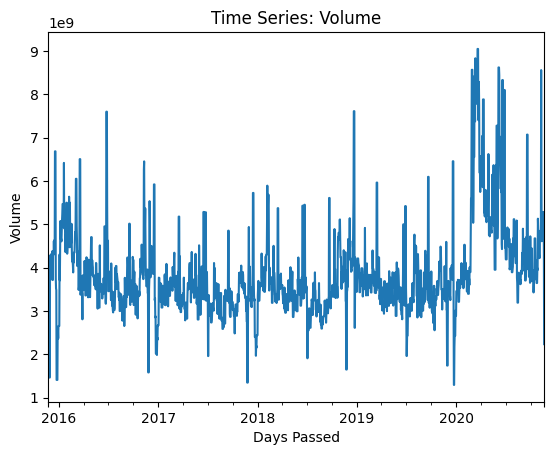

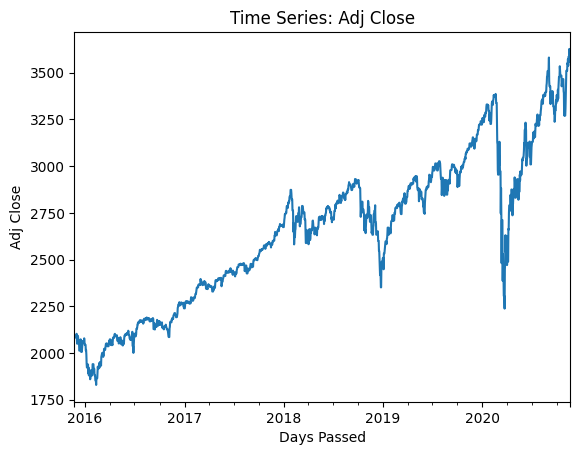

In [4]:
for col in columns:
    plt.figure()
    df[col].plot(title=f"Time Series: {col}")
    plt.xlabel("Days Passed")
    plt.ylabel(col)
    plt.show()

<Figure size 2000x1600 with 0 Axes>

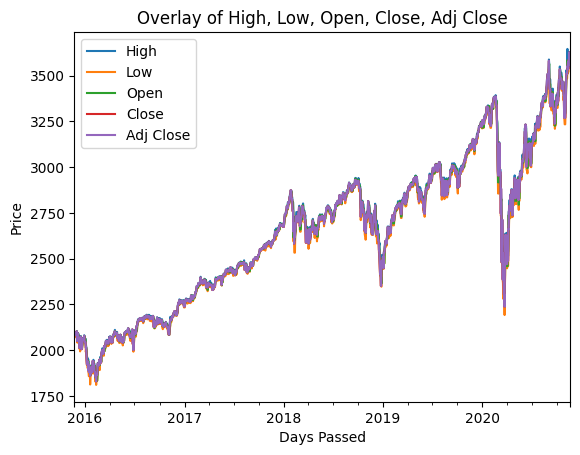

In [5]:
overlapping = ['High', 'Low', 'Open', 'Close', 'Adj Close']
plt.figure(figsize=(20, 16))
df[overlapping].plot()
plt.title("Overlay of High, Low, Open, Close, Adj Close")
plt.xlabel("Days Passed")
plt.ylabel("Price")
plt.show()

We see that Market High, Low, Open, Close, and Adjusted Close Price are extremely close in value. They move together, have identical seasonality, and over 5 years seem to move in step with each other.

<Figure size 2000x1600 with 0 Axes>

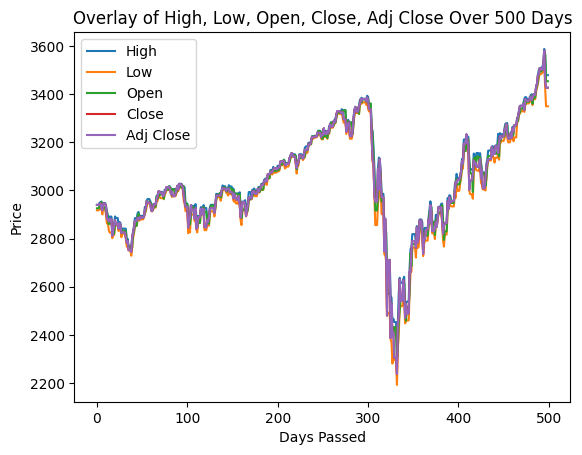

<Figure size 2000x1600 with 0 Axes>

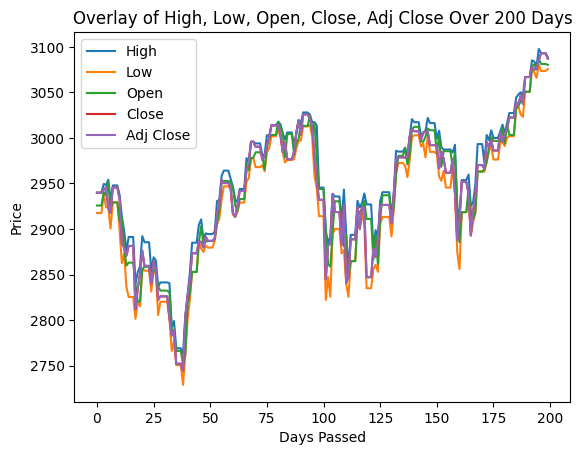

<Figure size 2000x1600 with 0 Axes>

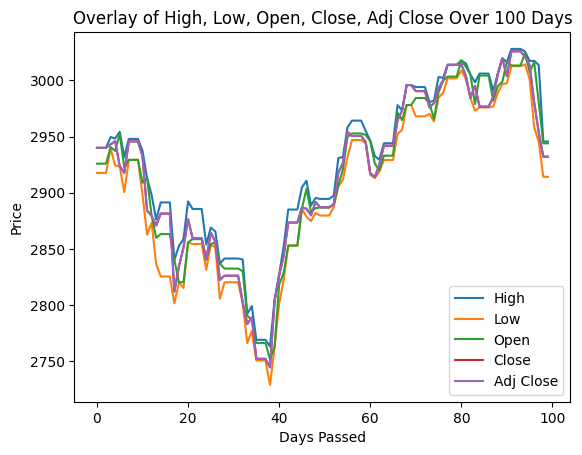

<Figure size 2000x1600 with 0 Axes>

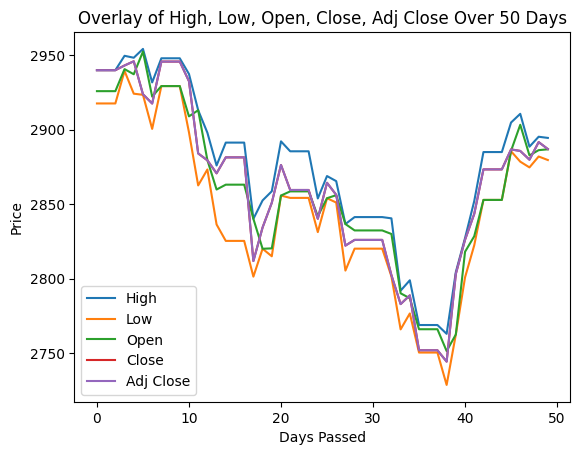

<Figure size 2000x1600 with 0 Axes>

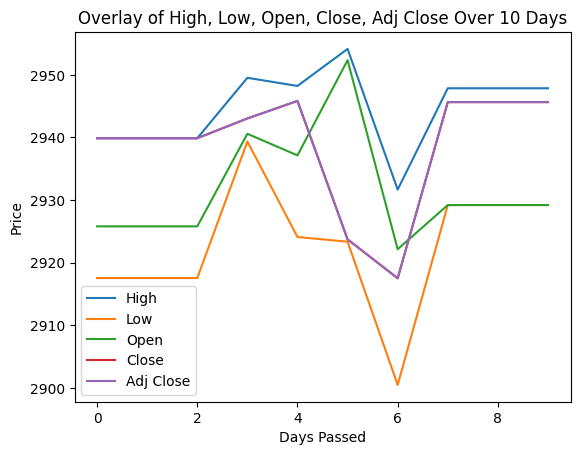

<Figure size 2000x1600 with 0 Axes>

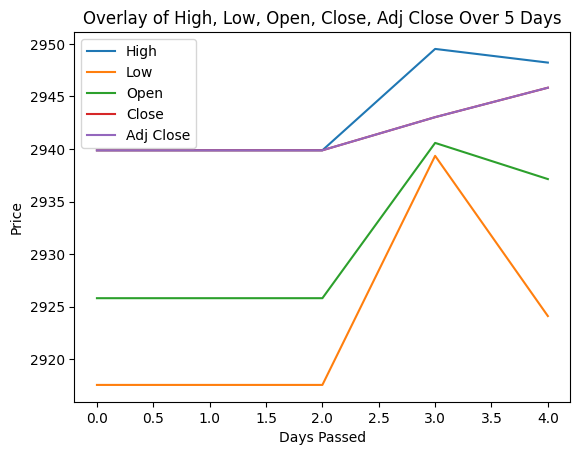

In [6]:
intervals = [5, 10, 50, 100, 200, 500]
for interval in reversed(intervals):
    plt.figure(figsize=(20, 16))
    df[overlapping].iloc[1250:(1250 + interval)].reset_index(drop=True).plot()
    plt.title(f"Overlay of High, Low, Open, Close, Adj Close Over {interval} Days")
    plt.xlabel("Days Passed")
    plt.ylabel("Price")
    plt.show()

Here we can clearly see as we decrease the observed time span we notice a lot more noise in the data. Although long term the data moves together, short term variance is high.

Maybe in these trends we can find a pattern that can act as signal for black swan events?

<Figure size 2000x1600 with 0 Axes>

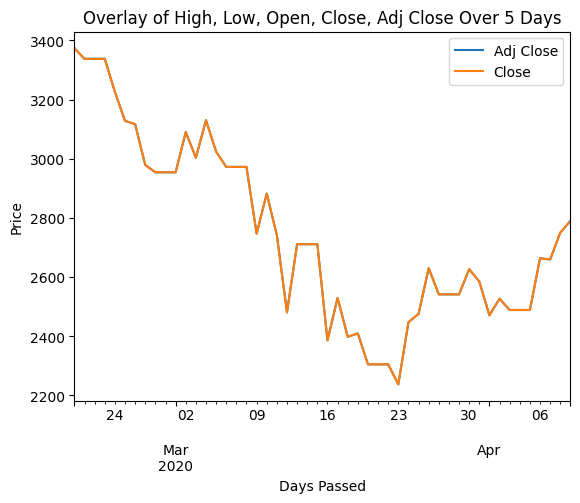

In [7]:
closing = ['Adj Close', 'Close']
plt.figure(figsize=(20, 16))
df[closing].iloc[1550:1600].plot()
plt.title(f"Overlay of High, Low, Open, Close, Adj Close Over {interval} Days")
plt.xlabel("Days Passed")
plt.ylabel("Price")
plt.show()

Adj Close and Close identical even during extreme events. Seems to have no impact on data

In [8]:
series = df['Close'].dropna()

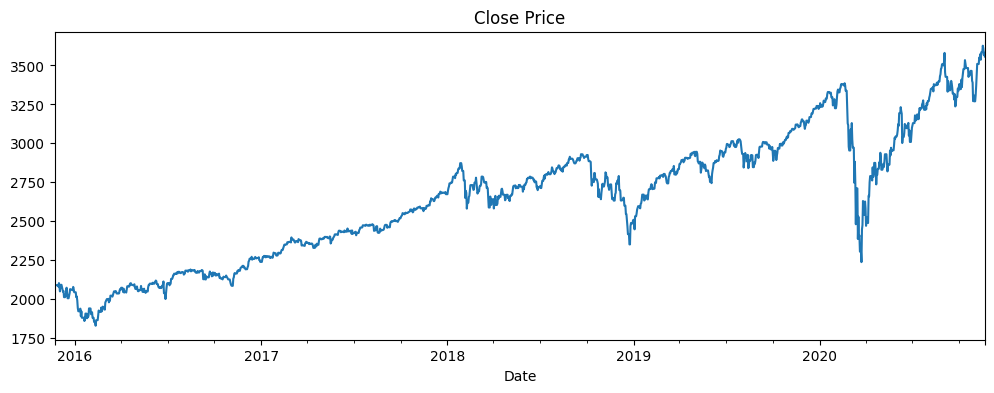

In [9]:
plt.figure(figsize=(12,4))
series.plot(title='Close Price')
plt.show()

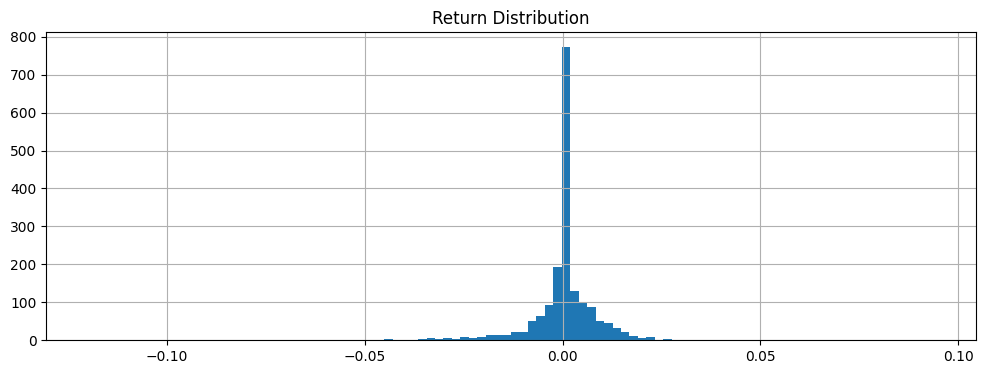

In [10]:
returns = series.pct_change().dropna()
plt.figure(figsize=(12,4))
returns.hist(bins=100)
plt.title("Return Distribution")
plt.show()

<Figure size 600x400 with 0 Axes>

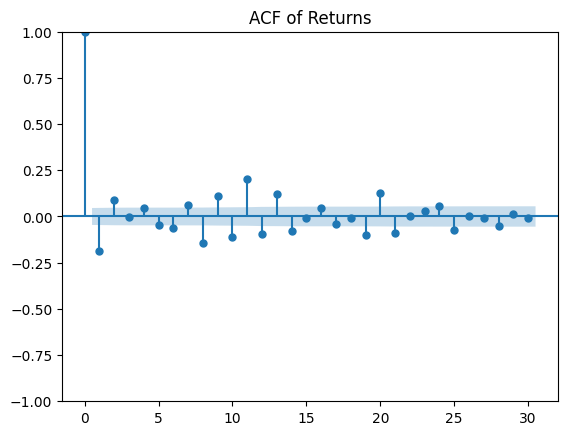

In [11]:
plt.figure(figsize=(6,4))
plot_acf(returns, lags=30)
plt.title("ACF of Returns")
plt.show()

In [12]:
result = adfuller(series)
print("ADF p-value on price:", result[1])

ADF p-value on price: 0.7975646340657587


In [13]:
series_diff = series.diff().dropna()
result2 = adfuller(series_diff)
print("ADF p-value on diff:", result2[1])

ADF p-value on diff: 1.0930862670334317e-13


<Figure size 600x400 with 0 Axes>

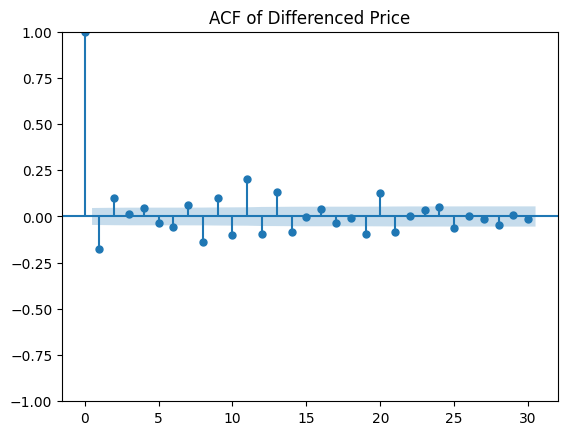

<Figure size 600x400 with 0 Axes>

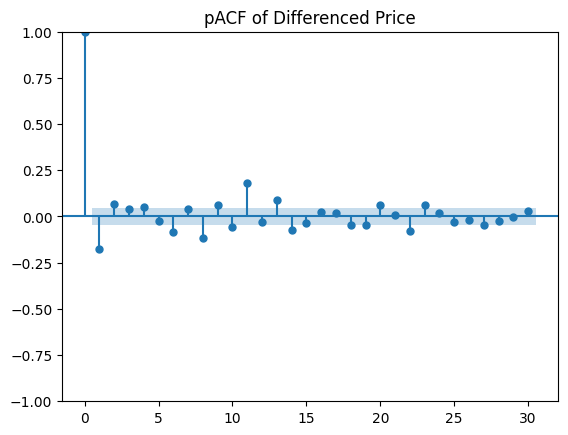

In [14]:
plt.figure(figsize=(6,4))
plot_acf(series_diff, lags=30)
plt.title("ACF of Differenced Price")
plt.show()
plt.figure(figsize=(6,4))
plot_pacf(series_diff, lags=30, method='ywm')
plt.title("pACF of Differenced Price")
plt.show()

In [15]:
n = len(series)
train_size = int(0.8 * n)
series_train = series.iloc[:train_size]
series_test  = series.iloc[train_size:]

In [16]:
best_aic = np.inf
best_order = None
for p in range(5):
    for q in range(5):
        for d in range(5):
            model = ARIMA(series_train, order=(p,d,q))
            res = model.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p,d,q)
print("Best ARIMA order:", best_order, "AIC:", best_aic)

/opt/anaconda3/envs/projects/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/projects/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/projects/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/projects/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt

Best ARIMA order: (4, 1, 4) AIC: 12449.242118696902


In [17]:
p,d,q = best_order
model = ARIMA(series_train, order=(p,d,q))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1460
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -6215.621
Date:                Fri, 20 Jun 2025   AIC                          12449.242
Time:                        13:25:09   BIC                          12496.812
Sample:                    11-23-2015   HQIC                         12466.988
                         - 11-21-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1961      0.028      7.078      0.000       0.142       0.250
ar.L2         -0.7130      0.028    -25.361      0.000      -0.768      -0.658
ar.L3          0.1892      0.027      7.135      0.0

/opt/anaconda3/envs/projects/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
steps = len(series_test)
forecast_res = fitted.get_forecast(steps=steps)
forecast = forecast_res.predicted_mean
ci = forecast_res.conf_int()

forecast.index = series_test.index

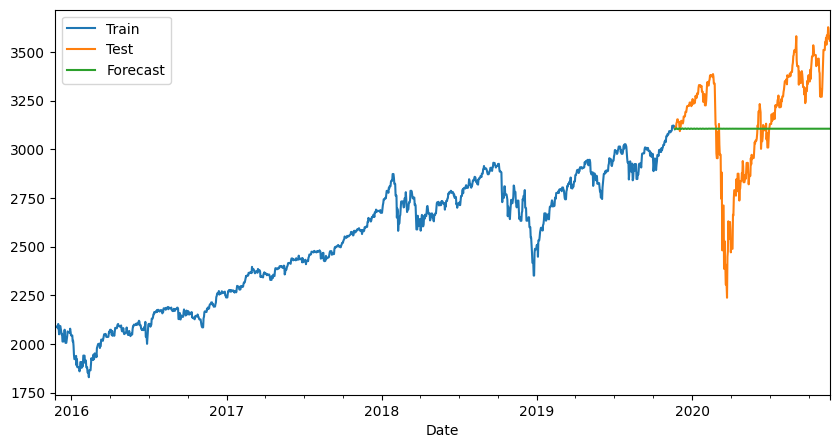

In [19]:
plt.figure(figsize=(10,5))
series_train.plot(label='Train')
series_test.plot(label='Test')
forecast.plot(label='Forecast')
plt.legend()
plt.show()

In [20]:
mape = np.mean(np.abs((series_test - forecast)/series_test))*100
rmse = np.sqrt(np.mean((series_test - forecast)**2))
print(f"Test MAPE: {mape:.2f}%, RMSE: {rmse:.4f}")

Test MAPE: 7.42%, RMSE: 278.0860


In [21]:
naive_fc = series_test.shift(1).iloc[1:]

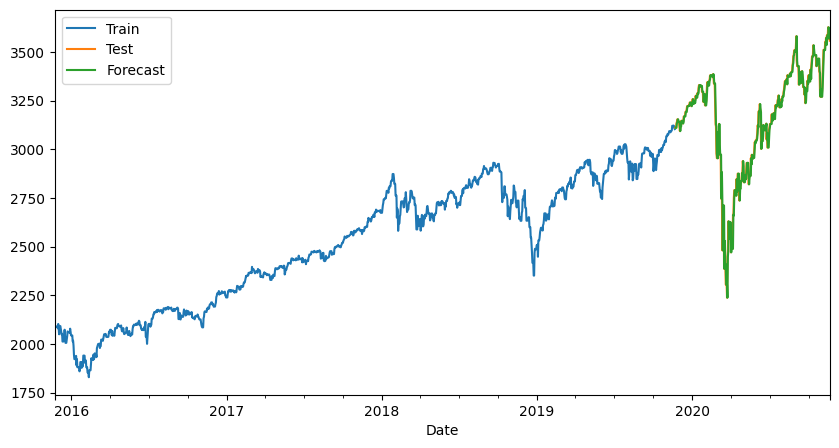

In [22]:
plt.figure(figsize=(10,5))
series_train.plot(label='Train')
series_test.plot(label='Test')
naive_fc.plot(label='Forecast')
plt.legend()
plt.show()

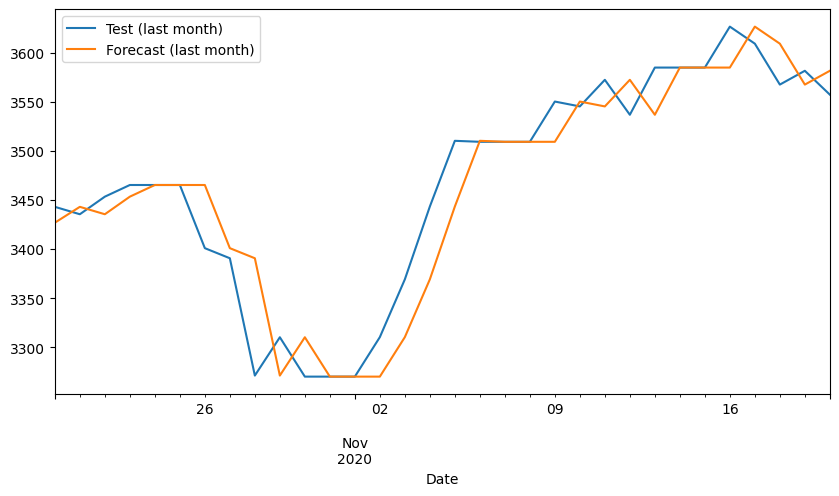

In [24]:
end = series_test.index[-1]
start = end - pd.DateOffset(months=1)
test_month = series_test.loc[start:end]
fc_month   = naive_fc.loc[start:end]

plt.figure(figsize=(10,5))
test_month.plot(label='Test (last month)')
fc_month.plot(label='Forecast (last month)')
plt.legend()
plt.show()

In [118]:
actual = series_test.iloc[1:]
naive_mape = np.mean(np.abs((actual - naive_fc) / actual)) * 100
naive_rmse = np.sqrt(np.mean((actual - naive_fc)**2))
print(f"Naive MAPE: {naive_mape:.2f}%, , RMSE: {rmse:.4f}")

Naive MAPE: 0.94%, , RMSE: 278.0860


So we see ARIMA fails miserably at forecasting closing prices for the S&P 500. Let us look into other methods to redeem ourselves. Naive method is just a one day offset—which reports a mean absolute percent error of sub 1%, while ARIMA reports 7%.

We can actually draw a few interesting conclusions from this. As stock prices are not seasonal, ARIMA doesn't really have anything to go off of. This will make the "naive" method far superior as prices tend to be correlated with neighboring prices but don't cycle in any noticeable patterns. This is due to the markets behaving in a random walk sort of manner, which ARIMA just isn't good at forecasting (nothing really is).

A one time pass algorithm will be hard to pull off. We can't predict a random walk from a node far away from prediction site. Thus let us try some rolling methods.

Instead of implementing an in house rolling EMA (estimated moving average) I will implement an LSTM Model as I don't have any import restrictions for this project. LSTM's are Long Short-Term Memory Model's that are good at making predictions based on recent patterns. Used in a lot of fields, including Time Series Forecasting. Let's see where this takes us.

In [91]:
data = df[['Close']]

In [92]:
df.reset_index(inplace=True)
data.head()

,Close
0,2086.590088
1,2089.139893
2,2088.870117
3,2088.870117
4,2090.110107


In [93]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [94]:
dates = test[['Date']]

In [95]:
data = data[['Close']]

In [96]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

We minmax scale to ensure model can learn regardless of data size. It will essentialy reduce vectors in Network to Unit vectors

In [97]:
def make_data(scaled_data):
    inputs = []
    labels = []

    for i in range(len(scaled_data) - 50):
        inputs.append(scaled_data[i:i+50])
        labels.append(scaled_data[i+50])

    return inputs, labels

x, y = make_data(scaled_data)

In [98]:
print(f"Number of data points in x are : {len(x)}")

Number of data points in x are : 1775


In [99]:
x = np.array(x)
y = np.array(y)

In [100]:
print(f"Shape of x is {x.shape}")

Shape of x is (1775, 50, 1)


In [101]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print(f"Size of training data : {x_train.shape[0]}")
print(f"Size of testing data : {x_test.shape[0]}")

Size of training data : 1420
Size of testing data : 355


In [102]:
import sys
print(sys.executable)
print(sys.version)

/opt/anaconda3/envs/projects/bin/python
3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]


In [103]:
import tensorflow

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, activation = "relu", input_shape=(50, 1)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

/opt/anaconda3/envs/projects/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1734 - val_loss: 0.0026
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 8.2188e-04
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2784e-04 - val_loss: 7.5806e-04
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5572e-04 - val_loss: 7.0050e-04
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7155e-04 - val_loss: 6.6596e-04
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9488e-04 - val_loss: 7.6328e-04
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3377e-04 - val_loss: 6.0307e-04
Epoch 9/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.8534e-04 - val_loss: 9.1269e-04
Epoch 10/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1464e-04 - val_loss: 5.8980e-04
Epoch 11/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.1141e-04 - val_loss: 5.9496e-04
Epoch 

In [106]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, 31, 1)

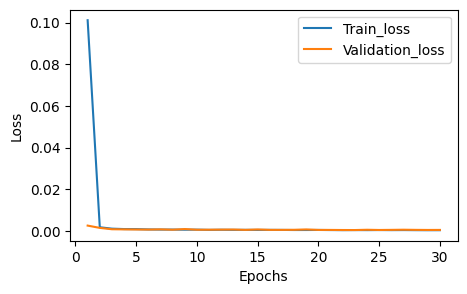

In [107]:
plt.figure(figsize=(5, 3))
plt.plot(epochs, train_loss, label='Train_loss')
plt.plot(epochs, val_loss, label='Validation_loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

Not overfit. None of the classic signals, no increase in validation loss once training loss plateaus. :).

In [108]:
predictions = model.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [109]:
predictions.shape

(355, 1)

In [111]:
y_pred = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

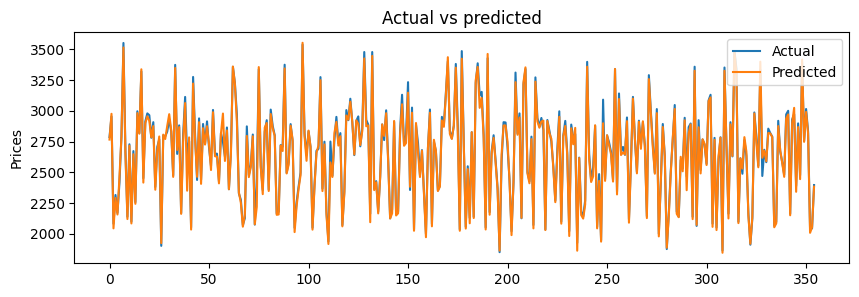

In [ ]:
plt.figure(figsize=(10, 3))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Actual vs predicted")
plt.ylabel("Close Prices")
plt.show()

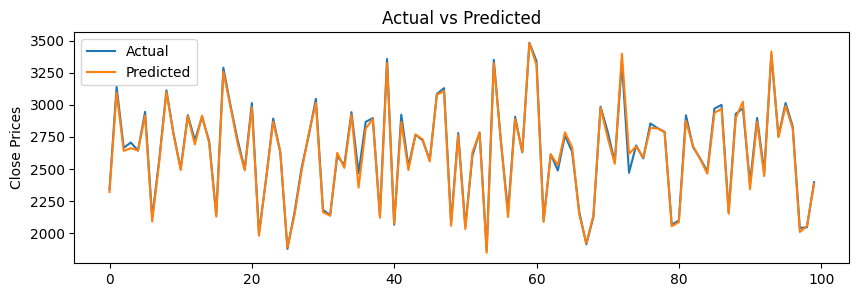

In [115]:
plt.figure(figsize=(10, 3))
plt.plot(y_test[-100:], label='Actual')
plt.plot(y_pred[-100:], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted")
plt.ylabel("Close Prices")
plt.show()

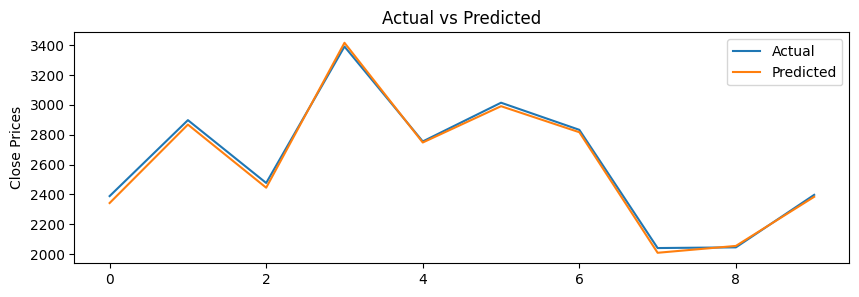

In [116]:
plt.figure(figsize=(10, 3))
plt.plot(y_test[-10:], label='Actual')
plt.plot(y_pred[-10:], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted")
plt.ylabel("Close Prices")
plt.show()

In [117]:
lstm_mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
lstm_rmse = np.sqrt(np.mean((y_test - y_pred)**2))
print(f"Test MAPE: {lstm_mape:.2f}%, RMSE: {lstm_rmse:.4f}")

Test MAPE: 1.00%, RMSE: 40.1321


Slightly higher MAPE than the Naive method, but the RMSE is significantly less, meaning we miss more but we also are less off when we miss!